In [1]:
import pm4py
import pandas

#dataPath = "E:\Data\DOI-10-13012-b2idb-0647142_v3\PhoenixBLN-NYT_1980-2018.csv"
dataPath = "/media/sasha/HDD-bigboy/Data/DOI-10-13012-b2idb-0647142_v3/PhoenixBLN-NYT_1980-2018.csv"

In [24]:
def code2text_Pheonix(event_log):
    #translatets root_codes for pheonix data
    translationMap = {"1":"Make Public Statement", "2":"Appeal", "3":"Express intent to cooperate",
                    "4":"Consult", "5":"Engage in diplomatic cooperation","6":"Engage in material cooperation",
                    "7":"Provide aid", "8":"Yield", "9":"Investigate", 
                    "10":"Demand", "11":"Disapprove", "12":"Reject", 
                    "13":"Threaten", "14":"Protest", "15":"Exhibit force posture", 
                    "16":"Reduce relations", "17":"Coerce", "18":"Assault",
                    "19":"Fight","20":"Use unconventional mass violence"}
    def translate(x):
        return translationMap[str(x)]
    event_log['root_code_text'] = event_log['root_code'].apply(translate)    
    return event_log

def preprocess(event_log, key="empty", remove_activity_keys=[]):
    #remove activities
    if len(remove_activity_keys) > 0:
        for code_key in remove_activity_keys:
            event_log = event_log[event_log.root_code != code_key]
            print(event_log["root_code"])
            
    #extract root country
    event_log["source_root"] = event_log["source"].apply(lambda x : x[0:3])
    event_log["target_root"] = event_log["target"].apply(lambda x : x[0:3])
    #create conflict_id
    event_log["conflict_id"] = event_log["source_root"] + event_log["target_root"]
    #select conflict
    if key != "empty":
        event_log = event_log[event_log.conflict_id == key]

    #event_log = event_log[event_log.source == "DDR"]
    #decode codes
    event_log = code2text_Pheonix(event_log)
    

    

    #format to pm4py
    event_log = pm4py.format_dataframe(event_log, case_id='conflict_id', activity_key='root_code_text', timestamp_key='story_date')
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

def import_csv(file_path):
    event_log = pandas.read_csv(file_path, sep=',')
    return event_log 

In [36]:
def make_process_tree(event_log, show=True):
    process_tree = pm4py.discover_process_tree_inductive(event_log)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    if(show):
        pm4py.view_bpmn(bpmn_model)
    return process_tree

def make_dfg(event_log, minThresh = 1, max_path_denoise=True, show=True):
    dfg, start_activities, end_activities = pm4py.discover_dfg(event_log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
    print(start_activities)
    if max_path_denoise:
        #keep only the largest in and out edges for each activity as well as remove self loops
        dfg = {activities: value for activities, value in dfg.items() if activities[0] != activities[1] and (value >= max([x for k,x in dfg.items() if k[0] == activities[0]])
                                                                                                            or value >= max([x for k,x in dfg.items() if k[1] == activities[1]]))}
    dfg = {activities: value for activities, value in dfg.items() if value >= minThresh}

    if show:
        pm4py.view_dfg(dfg, start_activities, end_activities, format='png')

def make_petrinet(event_log, show=True):
    #no clue what markings are but this should get us a petrinet
    #network, iMarking, fMarking = pm4py.discovery.discover_petri_net_alpha(event_log)
    #network, iMarking, fMarking = pm4py.discover_petri_net_inductive(event_log,noise_threshold = 0.7)
    network, iMarking, fMarking = pm4py.discover_petri_net_heuristics(event_log)
    if show:
        pm4py.view_petri_net(network, iMarking, fMarking)
    return network, iMarking, fMarking
def make_bpmn(event_log, show=True):
    efg = pm4py.discover_bpmn_inductive(event_log, noise_threshold = 0.7, multi_processing=True)
    if show:
        pm4py.view_bpmn(efg)
    return efg

1          11
2           6
3           3
6           3
7          19
           ..
1416957     6
1416958    11
1416959    13
1416960     3
1416961    19
Name: root_code, Length: 1131027, dtype: int64
1          11
2           6
7          19
8          10
9          19
           ..
1416954    19
1416957     6
1416958    11
1416959    13
1416961    19
Name: root_code, Length: 914315, dtype: int64
1          11
2           6
7          19
8          10
9          19
           ..
1416954    19
1416957     6
1416958    11
1416959    13
1416961    19
Name: root_code, Length: 718247, dtype: int64
Start activities: {'Coerce': 1}
End activities: {'Coerce': 1}
{'Coerce': 1}


/home/sasha/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/sasha/.local/lib/py

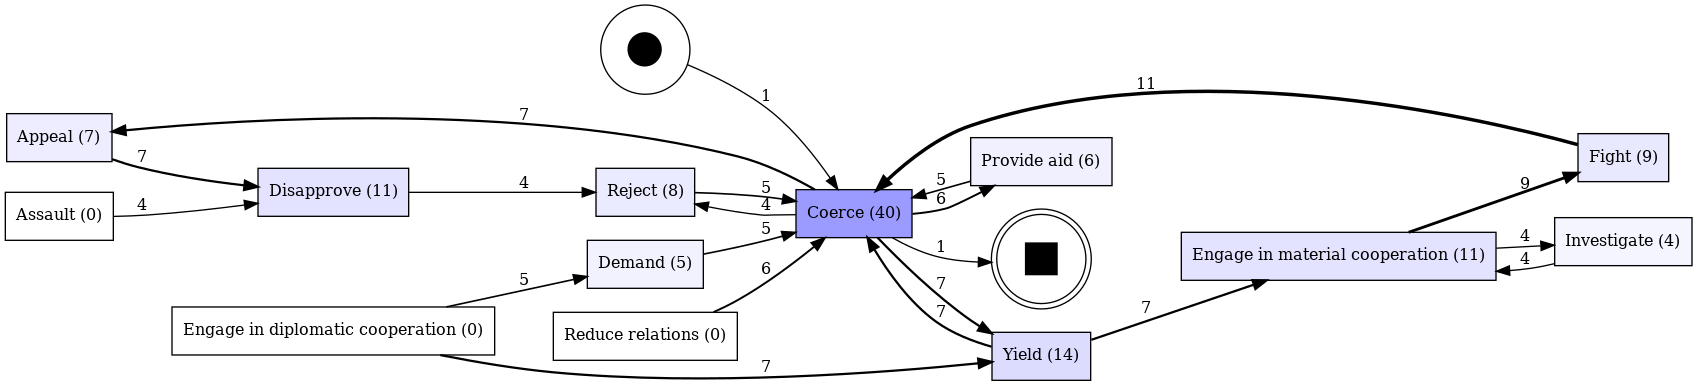

In [39]:
#selector block, config and select stuff here

event_log = import_csv(dataPath)
event_log_r = preprocess(event_log,key="USACUB", remove_activity_keys=[1,3,4])
make_dfg(event_log_r,minThresh =4)
#make_bpmn(event_log)
#make_process_tree(event_log)
#make_petrinet(event_log)